In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2021/train.csv
/kaggle/input/tabular-playground-series-apr-2021/test.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [3]:
!pwd

/kaggle/working


In [4]:
train = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')

In [5]:
import pandas_profiling
train.profile_report()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
data = pd.concat([train, test], sort = False)

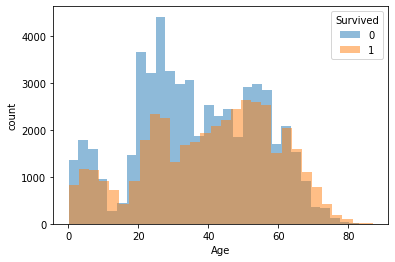

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(train.loc[train['Survived'] ==0, 'Age'].dropna(), bins=30, alpha = 0.5, label='0')
plt.hist(train.loc[train['Survived'] ==1, 'Age'].dropna(), bins=30, alpha = 0.5, label='1')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(title='Survived')

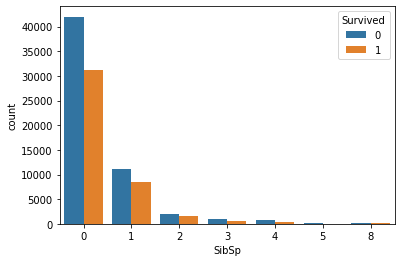

In [8]:
sns.countplot(x='SibSp', hue='Survived', data = train)
plt.legend(loc='upper right', title='Survived')

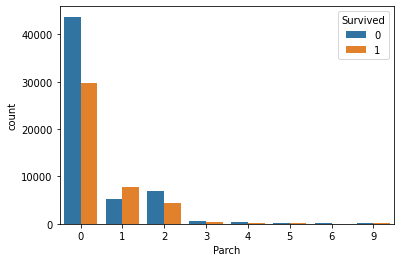

In [9]:
sns.countplot(x='Parch', hue='Survived', data = train)
plt.legend(loc='upper right', title='Survived')

(-5.0, 250.0)

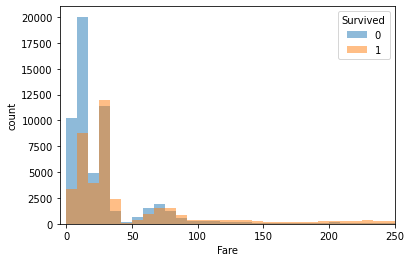

In [10]:
# The higher the fare, the higher the survival rate.
plt.hist(train.loc[train['Survived'] ==0, 'Fare'].dropna(), range=(0, 250), bins=30, alpha = 0.5, label='0')
plt.hist(train.loc[train['Survived'] ==1, 'Fare'].dropna(), range=(0, 250), bins=30, alpha = 0.5, label='1')
plt.xlabel('Fare')
plt.ylabel('count')
plt.legend(title='Survived')
plt.xlim(-5, 250)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

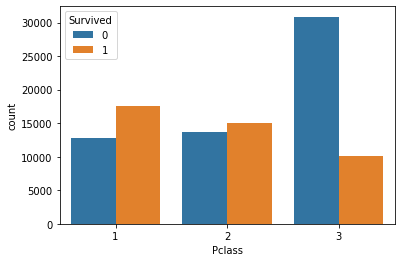

In [11]:
sns.countplot(x='Pclass', hue='Survived', data = train)

<AxesSubplot:xlabel='Sex', ylabel='count'>

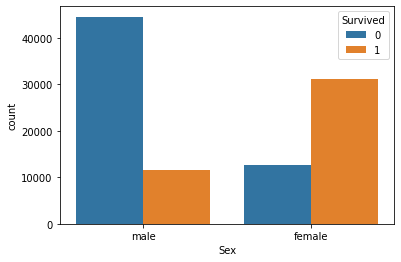

In [12]:
sns.countplot(x='Sex', hue='Survived', data = train)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

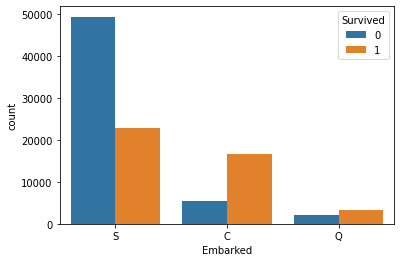

In [13]:
sns.countplot(x='Embarked', hue='Survived', data = train)

In [14]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  200000 non-null  int64  
 1   Survived     200000 non-null  int64  
 2   Pclass       200000 non-null  int64  
 3   Name         200000 non-null  object 
 4   Sex          200000 non-null  object 
 5   Age          193416 non-null  float64
 6   SibSp        200000 non-null  int64  
 7   Parch        200000 non-null  int64  
 8   Ticket       190754 non-null  object 
 9   Fare         199732 non-null  float64
 10  Cabin        64268 non-null   object 
 11  Embarked     199500 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 19.8+ MB


In [15]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [16]:
data.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age              6584
SibSp               0
Parch               0
Ticket           9246
Fare              268
Cabin          135732
Embarked          500
dtype: int64

In [17]:
#Embarked
data['Embarked'].value_counts() 

S    144278
C     44374
Q     10848
Name: Embarked, dtype: int64

In [18]:
 
#  3   Name         200000 non-null  object                          -- label_cols
#  4   Sex          200000 non-null  object                          -- label_cols
#  5   Age          193416 non-null  float64    -- missing value 
#  8   Ticket       190754 non-null  object     -- missing value     -- label_cols
#  9   Fare         199732 non-null  float64    -- missing value 
#  10  Cabin        64268 non-null   object     -- missing value     -- onehot_cols
#  11  Embarked     199500 non-null  object     -- missing value     -- onehot_cols

# https://www.kaggle.com/hiro5299834/tps-apr-2021-pseudo-labeling-voting-ensemble


# Name, take only surnames
data['Name'] = data['Name'].map(lambda x: x.split(',')[0])

age_avg = data['Age'].mean()
age_std = data['Age'].std()
data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)


# Ticket, fillna with 'X', split string and take first split 
data['Ticket'] = data['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

# Cabin, fillna with 'X' and take first letter
data['Cabin'] = data['Cabin'].fillna('X').map(lambda x: x[0].strip())

# Embarked, fillna with 'X' value
data['Embarked'] = data['Embarked'].fillna('X')

In [19]:
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2, 'X':3}).astype(int)
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)

In [20]:
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  200000 non-null  int64  
 1   Survived     200000 non-null  int64  
 2   Pclass       200000 non-null  int64  
 3   Name         200000 non-null  object 
 4   Sex          200000 non-null  int64  
 5   Age          200000 non-null  float64
 6   SibSp        200000 non-null  int64  
 7   Parch        200000 non-null  int64  
 8   Ticket       200000 non-null  object 
 9   Fare         200000 non-null  float64
 10  Cabin        200000 non-null  object 
 11  Embarked     200000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 19.8+ MB


In [22]:
data.Name.value_counts()

Smith        2324
Johnson      1900
Williams     1466
Jones        1362
Brown        1330
             ... 
Lickliter       2
Fraughton       2
Bybee           2
Breit           2
Prow            2
Name: Name, Length: 21558, dtype: int64

In [23]:
delete_columns = ['Name', 'PassengerId', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,0,51.00,2,0,27.14,0
1,0,3,0,51.00,0,0,13.35,0
2,0,3,0,0.33,1,2,71.29,0
3,0,3,0,19.00,0,0,13.04,0
4,1,3,0,25.00,0,0,7.76,0
...,...,...,...,...,...,...,...,...
99995,1,2,1,62.00,0,0,14.86,1
99996,0,2,0,66.00,0,0,11.15,0
99997,0,3,0,37.00,0,0,9.95,0
99998,0,3,0,51.00,0,1,30.92,0


In [24]:
target_df = data['Survived']
target_df

0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: Survived, Length: 200000, dtype: int64

In [25]:
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
x_test = test.drop('Survived', axis=1)
y_test= test['Survived']

In [26]:
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pclass    100000 non-null  int64  
 1   Sex       100000 non-null  int64  
 2   Age       100000 non-null  float64
 3   SibSp     100000 non-null  int64  
 4   Parch     100000 non-null  int64  
 5   Fare      100000 non-null  float64
 6   Embarked  100000 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 6.1 MB


In [28]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,51.00,2,0,27.14,0
1,3,0,51.00,0,0,13.35,0
2,3,0,0.33,1,2,71.29,0
3,3,0,19.00,0,0,13.04,0
4,3,0,25.00,0,0,7.76,0


NameError: name 'fig' is not defined

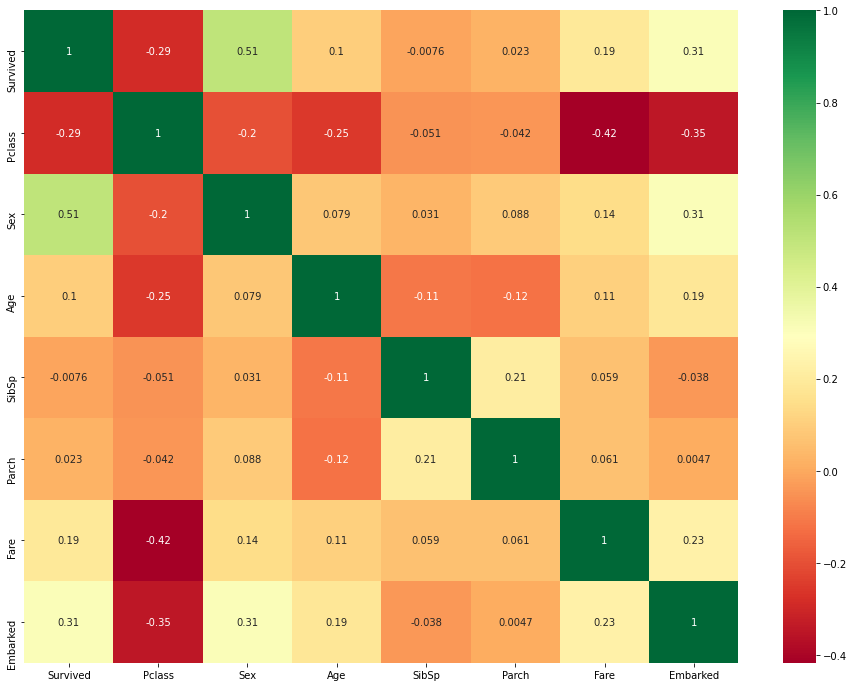

In [29]:
plt.subplots(figsize=(16,12))
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")
fig.tight_layout()
fig.show()

In [30]:
LGB Boost
Random Forest


SyntaxError: invalid syntax (<ipython-input-30-6a64a8fea0ad>, line 1)

# LightGBM

In [31]:
categorical_features = ['Embarked', 'Pclass', 'Sex']

In [32]:
from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3,random_state=0, stratify=y_train)

In [33]:
# Parameter tuning using Optuna(Grid Search 대신)
import optuna
from sklearn.metrics import log_loss

def objective(trial):
    params = {
        'objective': 'binary',
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'learning_rate': 0.05, #일반적으로 낮을수록 높은 성능
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }
    lgb_train = lgb.Dataset(X_train, y_train,
                            categorical_feature = categorical_features)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference = lgb_train,
                            categorical_feature = categorical_features)
    
    model = lgb.train(params, lgb_train,
                                   valid_sets=[lgb_train, lgb_eval],
                                   verbose_eval=10,
                                   num_boost_round=1000,
                                   early_stopping_rounds=10)

    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    score = log_loss(y_valid, y_pred)
    return score
                            

In [34]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2021-05-12 08:05:43,189] A new study created in memory with name: no-name-255f01d3-6363-4652-97a1-338977d48a24


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565011	valid_1's binary_logloss: 0.568188
[20]	training's binary_logloss: 0.515804	valid_1's binary_logloss: 0.521633
[30]	training's binary_logloss: 0.493188	valid_1's binary_logloss: 0.50153
[40]	training's binary_logloss: 0.482185	valid_1's binary_logloss: 0.493101
[50]	training's binary_logloss: 0.476127	valid_1's binary_logloss: 0.48959
[6

[I 2021-05-12 08:05:44,485] Trial 0 finished with value: 0.4874442940841824 and parameters: {'max_bin': 390, 'num_leaves': 101}. Best is trial 0 with value: 0.4874442940841824.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565657	valid_1's binary_logloss: 0.568315
[20]	training's binary_logloss: 0.516853	valid_1's binary_logloss: 0.521752
[30]	training's binary_logloss: 0.494594	valid_1's binary_logloss: 0.501653
[40]	training's binary_logloss: 0.483842	valid_1's binary_logloss: 0.493139
[50]	training's binary_logloss: 0.478006	valid_1's binary_logloss: 0.48962
[

[I 2021-05-12 08:05:45,734] Trial 1 finished with value: 0.4870087974876228 and parameters: {'max_bin': 403, 'num_leaves': 84}. Best is trial 1 with value: 0.4870087974876228.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565269	valid_1's binary_logloss: 0.568226
[20]	training's binary_logloss: 0.516186	valid_1's binary_logloss: 0.521741
[30]	training's binary_logloss: 0.493717	valid_1's binary_logloss: 0.501726
[40]	training's binary_logloss: 0.482761	valid_1's binary_logloss: 0.493195
[50]	training's binary_logloss: 0.47682	valid_1's binary_logloss: 0.489595
[

[I 2021-05-12 08:05:46,901] Trial 2 finished with value: 0.4872156480469103 and parameters: {'max_bin': 359, 'num_leaves': 94}. Best is trial 1 with value: 0.4870087974876228.


[80]	training's binary_logloss: 0.467318	valid_1's binary_logloss: 0.48723
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.468071	valid_1's binary_logloss: 0.487216
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.564395	valid_1's binary_logloss: 0.568128
[20]	training's binary_logloss: 0.514812	valid_1's binary_logloss: 0.521561
[30]	training's binary_logloss: 0.491817	v

[I 2021-05-12 08:05:48,265] Trial 3 finished with value: 0.48780217318752767 and parameters: {'max_bin': 362, 'num_leaves': 118}. Best is trial 1 with value: 0.4870087974876228.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.566291	valid_1's binary_logloss: 0.568532
[20]	training's binary_logloss: 0.517843	valid_1's binary_logloss: 0.521903
[30]	training's binary_logloss: 0.495876	valid_1's binary_logloss: 0.501715
[40]	training's binary_logloss: 0.485392	valid_1's binary_logloss: 0.49313
[50]	training's binary_logloss: 0.479818	valid_1's binary_logloss: 0.489378
[

[I 2021-05-12 08:05:49,597] Trial 4 finished with value: 0.4864073558033201 and parameters: {'max_bin': 492, 'num_leaves': 69}. Best is trial 4 with value: 0.4864073558033201.


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.466705	valid_1's binary_logloss: 0.486407
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565717	valid_1's binary_logloss: 0.568312
[20]	training's binary_logloss: 0.516862	valid_1's binary_logloss: 0.521689
[30]	training's binary_logloss: 0.494637	valid_1's binary_logloss: 0.501518
[40]	training's binary_logloss: 0.483909

[I 2021-05-12 08:05:50,968] Trial 5 finished with value: 0.48677067792383255 and parameters: {'max_bin': 449, 'num_leaves': 83}. Best is trial 4 with value: 0.4864073558033201.


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.465171	valid_1's binary_logloss: 0.486771
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.564301	valid_1's binary_logloss: 0.568076
[20]	training's binary_logloss: 0.514725	valid_1's binary_logloss: 0.521527
[30]	training's binary_logloss: 0.491692	valid_1's binary_logloss: 0.501437
[40]	training's binary_logloss: 0.480327	

[I 2021-05-12 08:05:52,401] Trial 6 finished with value: 0.48777268679815006 and parameters: {'max_bin': 394, 'num_leaves': 121}. Best is trial 4 with value: 0.4864073558033201.


[100]	training's binary_logloss: 0.457453	valid_1's binary_logloss: 0.48791
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.460304	valid_1's binary_logloss: 0.487773
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.568007	valid_1's binary_logloss: 0.569194
[20]	training's binary_logloss: 0.520495	valid_1's binary_logloss: 0.522722
[30]	training's binary_logloss: 0.499326	valid_1's binary_logloss: 0.502483
[40]	training's binary_loglos

[I 2021-05-12 08:05:53,949] Trial 7 finished with value: 0.4855589056597375 and parameters: {'max_bin': 272, 'num_leaves': 40}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.564669	valid_1's binary_logloss: 0.568157
[20]	training's binary_logloss: 0.515206	valid_1's binary_logloss: 0.521656
[30]	training's binary_logloss: 0.492419	valid_1's binary_logloss: 0.5017
[40]	training's binary_logloss: 0.481247	valid_1's binary_logloss: 0.493229
[50]	training's binary_logloss: 0.474934	valid_1's binary_logloss: 0.489714
[6

[I 2021-05-12 08:05:55,228] Trial 8 finished with value: 0.48778410283430246 and parameters: {'max_bin': 259, 'num_leaves': 112}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.564463	valid_1's binary_logloss: 0.568042
[20]	training's binary_logloss: 0.514917	valid_1's binary_logloss: 0.521494
[30]	training's binary_logloss: 0.491996	valid_1's binary_logloss: 0.501472
[40]	training's binary_logloss: 0.480645	valid_1's binary_logloss: 0.49303
[50]	training's binary_logloss: 0.474401	valid_1's binary_logloss: 0.489513
[

[I 2021-05-12 08:05:56,483] Trial 9 finished with value: 0.48779186995999424 and parameters: {'max_bin': 446, 'num_leaves': 116}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.564625	valid_1's binary_logloss: 0.568162
[20]	training's binary_logloss: 0.515187	valid_1's binary_logloss: 0.52162
[30]	training's binary_logloss: 0.492364	valid_1's binary_logloss: 0.501548
[40]	training's binary_logloss: 0.481128	valid_1's binary_logloss: 0.49303
[50]	training's binary_logloss: 0.474905	valid_1's binary_logloss: 0.489543
[6

[I 2021-05-12 08:05:57,885] Trial 10 finished with value: 0.4873202960684587 and parameters: {'max_bin': 495, 'num_leaves': 109}. Best is trial 7 with value: 0.4855589056597375.


Early stopping, best iteration is:
[92]	training's binary_logloss: 0.461486	valid_1's binary_logloss: 0.48732
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.564805	valid_1's binary_logloss: 0.568111
[20]	training's binary_logloss: 0.515441	valid_1's binary_logloss: 0.521517
[30]	training's binary_logloss: 0.492682	valid_1's binary_logloss: 0.501578
[40]	training's binary_logloss: 0.481581	v

[I 2021-05-12 08:05:59,197] Trial 11 finished with value: 0.4872932065937129 and parameters: {'max_bin': 368, 'num_leaves': 107}. Best is trial 7 with value: 0.4855589056597375.


[80]	training's binary_logloss: 0.465342	valid_1's binary_logloss: 0.487323
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.465896	valid_1's binary_logloss: 0.487293
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565278	valid_1's binary_logloss: 0.56822
[20]	training's binary_logloss: 0.516248	valid_1's binary_logloss: 0.521625
[30]	training's binary_logloss: 0.493822	v

[I 2021-05-12 08:06:00,455] Trial 12 finished with value: 0.48700732088606796 and parameters: {'max_bin': 284, 'num_leaves': 94}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.564305	valid_1's binary_logloss: 0.568141
[20]	training's binary_logloss: 0.514595	valid_1's binary_logloss: 0.521459
[30]	training's binary_logloss: 0.491603	valid_1's binary_logloss: 0.501362
[40]	training's binary_logloss: 0.480208	valid_1's binary_logloss: 0.492992
[50]	training's binary_logloss: 0.473818	valid_1's binary_logloss: 0.489691


[I 2021-05-12 08:06:01,868] Trial 13 finished with value: 0.4876060900538781 and parameters: {'max_bin': 290, 'num_leaves': 123}. Best is trial 7 with value: 0.4855589056597375.


[100]	training's binary_logloss: 0.457436	valid_1's binary_logloss: 0.487781
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.459913	valid_1's binary_logloss: 0.487606
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.566151	valid_1's binary_logloss: 0.5684
[20]	training's binary_logloss: 0.517624	valid_1's binary_logloss: 0.521745
[30]	training's binary_logloss: 0.495665	v

[I 2021-05-12 08:06:03,016] Trial 14 finished with value: 0.48660808636935093 and parameters: {'max_bin': 383, 'num_leaves': 72}. Best is trial 7 with value: 0.4855589056597375.


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.469932	valid_1's binary_logloss: 0.486608
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.564796	valid_1's binary_logloss: 0.568223
[20]	training's binary_logloss: 0.515429	valid_1's binary_logloss: 0.521657
[30]	training's binary_logloss: 0.492667	valid_1's binary_logloss: 0.501638
[40]	training's binary_logloss: 0.481561	

[I 2021-05-12 08:06:04,191] Trial 15 finished with value: 0.4876447485797418 and parameters: {'max_bin': 320, 'num_leaves': 107}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565537	valid_1's binary_logloss: 0.568257
[20]	training's binary_logloss: 0.516611	valid_1's binary_logloss: 0.521689
[30]	training's binary_logloss: 0.494323	valid_1's binary_logloss: 0.50168
[40]	training's binary_logloss: 0.483538	valid_1's binary_logloss: 0.493106
[50]	training's binary_logloss: 0.477667	valid_1's binary_logloss: 0.489393
[

[I 2021-05-12 08:06:05,402] Trial 16 finished with value: 0.4869528152512076 and parameters: {'max_bin': 367, 'num_leaves': 87}. Best is trial 7 with value: 0.4855589056597375.


[90]	training's binary_logloss: 0.466323	valid_1's binary_logloss: 0.486962
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.466721	valid_1's binary_logloss: 0.486953
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565433	valid_1's binary_logloss: 0.568297
[20]	training's binary_logloss: 0.516429	valid_1's binary_logloss: 0.521661
[30]	training's binary_logloss: 0.494033	

[I 2021-05-12 08:06:06,578] Trial 17 finished with value: 0.48727154703457054 and parameters: {'max_bin': 259, 'num_leaves': 91}. Best is trial 7 with value: 0.4855589056597375.


[90]	training's binary_logloss: 0.465632	valid_1's binary_logloss: 0.487367
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.467066	valid_1's binary_logloss: 0.487272
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565359	valid_1's binary_logloss: 0.568249
[20]	training's binary_logloss: 0.516325	valid_1's binary_logloss: 0.521657
[30]	training's binary_logloss: 0.493912	

[I 2021-05-12 08:06:08,861] Trial 18 finished with value: 0.4871116360881959 and parameters: {'max_bin': 405, 'num_leaves': 91}. Best is trial 7 with value: 0.4855589056597375.


[110]	training's binary_logloss: 0.460797	valid_1's binary_logloss: 0.487303
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.462721	valid_1's binary_logloss: 0.487112
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565093	valid_1's binary_logloss: 0.568236
[20]	training's binary_logloss: 0.515933	valid_1's binary_logloss: 0.521641
[30]	training's binary_logloss: 0.49335

[I 2021-05-12 08:06:10,194] Trial 19 finished with value: 0.4873719076787785 and parameters: {'max_bin': 487, 'num_leaves': 98}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.566048	valid_1's binary_logloss: 0.56848
[20]	training's binary_logloss: 0.517472	valid_1's binary_logloss: 0.521854
[30]	training's binary_logloss: 0.495482	valid_1's binary_logloss: 0.501789
[40]	training's binary_logloss: 0.484983	valid_1's binary_logloss: 0.493329
[50]	training's binary_logloss: 0.479332	valid_1's binary_logloss: 0.489622
[

[I 2021-05-12 08:06:11,468] Trial 20 finished with value: 0.48659579497655087 and parameters: {'max_bin': 343, 'num_leaves': 74}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.568251	valid_1's binary_logloss: 0.569368
[20]	training's binary_logloss: 0.520801	valid_1's binary_logloss: 0.522885
[30]	training's binary_logloss: 0.499709	valid_1's binary_logloss: 0.502685
[40]	training's binary_logloss: 0.489788	valid_1's binary_logloss: 0.493744
[50]	training's binary_logloss: 0.484726	valid_1's binary_logloss: 0.489816


[I 2021-05-12 08:06:12,826] Trial 21 finished with value: 0.4856035922137961 and parameters: {'max_bin': 426, 'num_leaves': 37}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565164	valid_1's binary_logloss: 0.568213
[20]	training's binary_logloss: 0.516008	valid_1's binary_logloss: 0.52156
[30]	training's binary_logloss: 0.4935	valid_1's binary_logloss: 0.501578
[40]	training's binary_logloss: 0.482516	valid_1's binary_logloss: 0.493084
[50]	training's binary_logloss: 0.476445	valid_1's binary_logloss: 0.489505
[60

[I 2021-05-12 08:06:14,193] Trial 22 finished with value: 0.4872663042344167 and parameters: {'max_bin': 419, 'num_leaves': 97}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567663	valid_1's binary_logloss: 0.569062
[20]	training's binary_logloss: 0.520011	valid_1's binary_logloss: 0.52251
[30]	training's binary_logloss: 0.498774	valid_1's binary_logloss: 0.502422
[40]	training's binary_logloss: 0.488766	valid_1's binary_logloss: 0.493443
[50]	training's binary_logloss: 0.483603	valid_1's binary_logloss: 0.489589
[

[I 2021-05-12 08:06:15,485] Trial 23 finished with value: 0.48588377496260193 and parameters: {'max_bin': 306, 'num_leaves': 44}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.566371	valid_1's binary_logloss: 0.568495
[20]	training's binary_logloss: 0.518027	valid_1's binary_logloss: 0.521911
[30]	training's binary_logloss: 0.496157	valid_1's binary_logloss: 0.50178
[40]	training's binary_logloss: 0.485743	valid_1's binary_logloss: 0.493121
[50]	training's binary_logloss: 0.480258	valid_1's binary_logloss: 0.489282
[

[I 2021-05-12 08:06:16,813] Trial 24 finished with value: 0.48642811455685137 and parameters: {'max_bin': 332, 'num_leaves': 67}. Best is trial 7 with value: 0.4855589056597375.


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.467207	valid_1's binary_logloss: 0.486428
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.566049	valid_1's binary_logloss: 0.568448
[20]	training's binary_logloss: 0.517531	valid_1's binary_logloss: 0.521852
[30]	training's binary_logloss: 0.495521	valid_1's binary_logloss: 0.501763
[40]	training's binary_logloss: 0.484997

[I 2021-05-12 08:06:18,228] Trial 25 finished with value: 0.48671104647104296 and parameters: {'max_bin': 395, 'num_leaves': 74}. Best is trial 7 with value: 0.4855589056597375.


[120]	training's binary_logloss: 0.463331	valid_1's binary_logloss: 0.486813
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.46481	valid_1's binary_logloss: 0.486711
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567923	valid_1's binary_logloss: 0.569222
[20]	training's binary_logloss: 0.52033	valid_1's binary_logloss: 0.522692
[30]	training's binary_logloss: 0.499088	

[I 2021-05-12 08:06:19,507] Trial 26 finished with value: 0.48571310459221445 and parameters: {'max_bin': 498, 'num_leaves': 41}. Best is trial 7 with value: 0.4855589056597375.


[120]	training's binary_logloss: 0.47191	valid_1's binary_logloss: 0.48576
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.472334	valid_1's binary_logloss: 0.485713
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567473	valid_1's binary_logloss: 0.568939
[20]	training's binary_logloss: 0.519733	valid_1's binary_logloss: 0.522415
[30]	training's binary_logloss: 0.498425	

[I 2021-05-12 08:06:20,935] Trial 27 finished with value: 0.48598351531325545 and parameters: {'max_bin': 306, 'num_leaves': 47}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.566945	valid_1's binary_logloss: 0.568702
[20]	training's binary_logloss: 0.518915	valid_1's binary_logloss: 0.522085
[30]	training's binary_logloss: 0.497324	valid_1's binary_logloss: 0.501863
[40]	training's binary_logloss: 0.487091	valid_1's binary_logloss: 0.49318
[50]	training's binary_logloss: 0.481694	valid_1's binary_logloss: 0.489246
[

[I 2021-05-12 08:06:22,235] Trial 28 finished with value: 0.4861003709590831 and parameters: {'max_bin': 415, 'num_leaves': 56}. Best is trial 7 with value: 0.4855589056597375.


[110]	training's binary_logloss: 0.469199	valid_1's binary_logloss: 0.486127
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.469341	valid_1's binary_logloss: 0.4861
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567032	valid_1's binary_logloss: 0.568716
[20]	training's binary_logloss: 0.518969	valid_1's binary_logloss: 0.522158
[30]	training's binary_logloss: 0.497369	

[I 2021-05-12 08:06:23,802] Trial 29 finished with value: 0.4860728935825631 and parameters: {'max_bin': 369, 'num_leaves': 55}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567867	valid_1's binary_logloss: 0.569151
[20]	training's binary_logloss: 0.520266	valid_1's binary_logloss: 0.522627
[30]	training's binary_logloss: 0.499064	valid_1's binary_logloss: 0.502402
[40]	training's binary_logloss: 0.48906	valid_1's binary_logloss: 0.493538
[50]	training's binary_logloss: 0.483938	valid_1's binary_logloss: 0.489561
[

[I 2021-05-12 08:06:25,105] Trial 30 finished with value: 0.4856201986560239 and parameters: {'max_bin': 294, 'num_leaves': 42}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567643	valid_1's binary_logloss: 0.569058
[20]	training's binary_logloss: 0.519878	valid_1's binary_logloss: 0.522435
[30]	training's binary_logloss: 0.498567	valid_1's binary_logloss: 0.502301
[40]	training's binary_logloss: 0.488536	valid_1's binary_logloss: 0.493416
[50]	training's binary_logloss: 0.483306	valid_1's binary_logloss: 0.489545


[I 2021-05-12 08:06:26,345] Trial 31 finished with value: 0.4858241127547928 and parameters: {'max_bin': 416, 'num_leaves': 45}. Best is trial 7 with value: 0.4855589056597375.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.566391	valid_1's binary_logloss: 0.568525
[20]	training's binary_logloss: 0.518047	valid_1's binary_logloss: 0.521932
[30]	training's binary_logloss: 0.496203	valid_1's binary_logloss: 0.501784
[40]	training's binary_logloss: 0.485843	valid_1's binary_logloss: 0.4932
[50]	training's binary_logloss: 0.480347	valid_1's binary_logloss: 0.489505
[6

[I 2021-05-12 08:06:27,563] Trial 32 finished with value: 0.48671367611996375 and parameters: {'max_bin': 303, 'num_leaves': 67}. Best is trial 7 with value: 0.4855589056597375.


[100]	training's binary_logloss: 0.468485	valid_1's binary_logloss: 0.486758
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.469203	valid_1's binary_logloss: 0.486714
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567877	valid_1's binary_logloss: 0.569173
[20]	training's binary_logloss: 0.52028	valid_1's binary_logloss: 0.522635
[30]	training's binary_logloss: 0.499029	

[I 2021-05-12 08:06:28,885] Trial 33 finished with value: 0.48519833428557957 and parameters: {'max_bin': 456, 'num_leaves': 41}. Best is trial 33 with value: 0.48519833428557957.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567867	valid_1's binary_logloss: 0.569153
[20]	training's binary_logloss: 0.520305	valid_1's binary_logloss: 0.522689
[30]	training's binary_logloss: 0.499118	valid_1's binary_logloss: 0.502504
[40]	training's binary_logloss: 0.4891	valid_1's binary_logloss: 0.493535
[50]	training's binary_logloss: 0.484034	valid_1's binary_logloss: 0.489684
[6

[I 2021-05-12 08:06:30,211] Trial 34 finished with value: 0.485738295849276 and parameters: {'max_bin': 461, 'num_leaves': 41}. Best is trial 33 with value: 0.48519833428557957.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565913	valid_1's binary_logloss: 0.568419
[20]	training's binary_logloss: 0.517246	valid_1's binary_logloss: 0.521725
[30]	training's binary_logloss: 0.495124	valid_1's binary_logloss: 0.501669
[40]	training's binary_logloss: 0.484527	valid_1's binary_logloss: 0.493086
[50]	training's binary_logloss: 0.478751	valid_1's binary_logloss: 0.489351


[I 2021-05-12 08:06:31,649] Trial 35 finished with value: 0.48675652452038565 and parameters: {'max_bin': 495, 'num_leaves': 77}. Best is trial 33 with value: 0.48519833428557957.


Early stopping, best iteration is:
[96]	training's binary_logloss: 0.466633	valid_1's binary_logloss: 0.486757
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.565359	valid_1's binary_logloss: 0.568257
[20]	training's binary_logloss: 0.516305	valid_1's binary_logloss: 0.521686
[30]	training's binary_logloss: 0.493919	valid_1's binary_logloss: 0.501642
[40]	training's binary_logloss: 0.483073	

[I 2021-05-12 08:06:33,054] Trial 36 finished with value: 0.4869217176591013 and parameters: {'max_bin': 495, 'num_leaves': 90}. Best is trial 33 with value: 0.48519833428557957.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.568418	valid_1's binary_logloss: 0.569497
[20]	training's binary_logloss: 0.521048	valid_1's binary_logloss: 0.523072
[30]	training's binary_logloss: 0.50001	valid_1's binary_logloss: 0.50284
[40]	training's binary_logloss: 0.49013	valid_1's binary_logloss: 0.493894
[50]	training's binary_logloss: 0.485158	valid_1's binary_logloss: 0.489969
[60

[I 2021-05-12 08:06:34,588] Trial 37 finished with value: 0.48551734890445036 and parameters: {'max_bin': 436, 'num_leaves': 35}. Best is trial 33 with value: 0.48519833428557957.


[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 498
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567747	valid_1's binary_logloss: 0.569113
[20]	training's binary_logloss: 0.520076	valid_1's binary_logloss: 0.522506
[30]	training's binary_logloss: 0.498826	valid_1's binary_logloss: 0.502326
[40]	training's binary_logloss: 0.488809	valid_1's binary_logloss: 0.49347
[50]	training's binary_logloss: 0.483712	valid_1's binary_logloss: 0.489609
[

[I 2021-05-12 08:06:36,025] Trial 38 finished with value: 0.4857419739419955 and parameters: {'max_bin': 324, 'num_leaves': 43}. Best is trial 33 with value: 0.48519833428557957.


[140]	training's binary_logloss: 0.469697	valid_1's binary_logloss: 0.485776
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.469981	valid_1's binary_logloss: 0.485742
[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567753	valid_1's binary_logloss: 0.569057
[20]	training's binary_logloss: 0.520111	valid_1's binary_logloss: 0.522488
[30]	training's binary_logloss: 0.49886

[I 2021-05-12 08:06:37,435] Trial 39 finished with value: 0.48576800951003746 and parameters: {'max_bin': 327, 'num_leaves': 43}. Best is trial 33 with value: 0.48519833428557957.


[140]	training's binary_logloss: 0.469422	valid_1's binary_logloss: 0.485799
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.469827	valid_1's binary_logloss: 0.485768


In [35]:
study.best_params

{'max_bin': 456, 'num_leaves': 41}

In [36]:
params = {
    'objective': 'binary',
    'max_bin': study.best_params['max_bin'],
    'learning_rate': 0.05,
    'num_leaves': study.best_params['num_leaves']
}

lgb_train = lgb.Dataset(X_train, y_train,categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train,categorical_feature=categorical_features)

model = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval],verbose_eval=10,num_boost_round=1000,early_stopping_rounds=10)

y_pred = model.predict(x_test, num_iteration=model.best_iteration)

[LightGBM] [Info] Number of positive: 29942, number of negative: 40058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427743 -> initscore=-0.291066
[LightGBM] [Info] Start training from score -0.291066
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.567877	valid_1's binary_logloss: 0.569173
[20]	training's binary_logloss: 0.52028	valid_1's binary_logloss: 0.522635
[30]	training's binary_logloss: 0.499029	valid_1's binary_logloss: 0.502359
[40]	training's binary_logloss: 0.489067	valid_1's binary_logloss: 0.493518
[50]	training's binary_logloss: 0.483999	valid_1's binary_logloss: 0.489654
[

In [37]:
y_pred[:10]

array([0.23385445, 0.08299208, 0.12914642, 0.09226727, 0.09073339,
       0.09695331, 0.09255288, 0.48909224, 0.31563518, 0.45603923])

In [38]:
y_pred = (y_pred > 0.5).astype(int)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
sample_submission['Survived'] = y_pred
sample_submission.to_csv('submission_lightgbm.csv', index=False)

sample_submission.head()

,PassengerId,Survived
0,100000,0
1,100001,0
2,100002,0
3,100003,0
4,100004,0
